# **0. Importación de Librerías**

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# **1. Carga del dataset**

In [7]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv" 
df = pd.read_csv(url, sep=';')

print(f"Dataset. Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

Dataset. Filas: 1599, Columnas: 12


## **1.1. Pulido del dataset**

In [8]:
# Crea la columna 'label' basada en 'quality'

def clasificar_vino(quality):
    if quality <= 5:
        return 0 
    elif quality == 6:
        return 1 
    else:
        return 2 

df['label'] = df['quality'].apply(clasificar_vino)

print("\nDistribución de la variable 'label'")
print(df['label'].value_counts().sort_index())


Distribución de la variable 'label'
label
0    744
1    638
2    217
Name: count, dtype: int64


# **2. X e Y**

In [9]:
# Separa X e y
# Eliminamos 'quality' de X porque 'label' deriva de ella (generaría data leakage)

X = df.drop(columns=['quality', 'label'])
y = df['label']

## **2.1. Separación de Train y Test**

In [14]:
# División en Train y Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **2.2. Escalado de Datos**

In [16]:
# 5. Escalado de datos con (StandardScaler)
# Ajustamos el escalador SOLO con X_train para no filtrar información al test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Media de Alcohol (antes de escalar): {X_train['alcohol'].mean():.2f}")
print(f"Media de Alcohol (después de escalar): {X_train_scaled[:, 10].mean():.2f}")

Media de Alcohol (antes de escalar): 10.42
Media de Alcohol (después de escalar): 0.00


# **3. Entrenamiento inicial y Evaluación del KNN**

In [18]:
# Entrena el modelo KNN (k=5)
k_inicial = 5
knn_model = KNeighborsClassifier(n_neighbors=k_inicial)

knn_model.fit(X_train_scaled, y_train)

# Predicciones en el set de prueba
knn_y_pred = knn_model.predict(X_test_scaled)

## **3.1. Evaluación del Rendimiento**

In [19]:
# Accuracy
accuracy = accuracy_score(y_test, knn_y_pred)

# Matriz de Confusión
cm = confusion_matrix(y_test, knn_y_pred)

# Reporte de Clasificación
report = classification_report(y_test, knn_y_pred, target_names=['Baja (0)', 'Media (1)', 'Alta (2)'])

print(f"\nResultados del KNN con k={k_inicial}")
print(f"Precisión (Accuracy): {accuracy:.4f}")

print("\nMatriz de Confusión:")
print(cm)

print("\nReporte de Clasificación:")
print(report)


Resultados del KNN con k=5
Precisión (Accuracy): 0.5844

Matriz de Confusión:
[[95 45  1]
 [50 72 10]
 [ 7 20 20]]

Reporte de Clasificación:
              precision    recall  f1-score   support

    Baja (0)       0.62      0.67      0.65       141
   Media (1)       0.53      0.55      0.54       132
    Alta (2)       0.65      0.43      0.51        47

    accuracy                           0.58       320
   macro avg       0.60      0.55      0.57       320
weighted avg       0.59      0.58      0.58       320



## **3.2. Guardado del modelo**

In [20]:
joblib.dump(knn_model, "knn_model_inicial.pkl")
print(f"\nModelo KNN guardado como 'knn_model_inicial.pkl'")


Modelo KNN guardado como 'knn_model_inicial.pkl'


# **4. Búsqueda del K Óptimo**

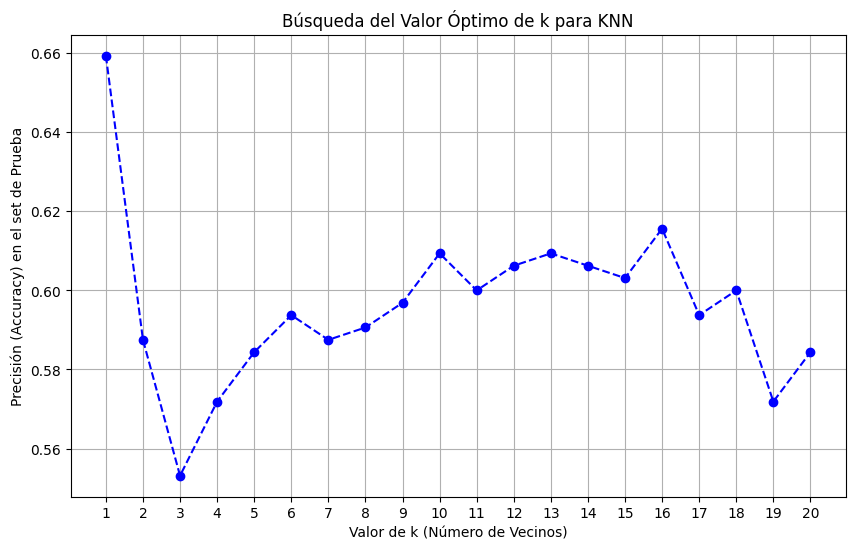


Resultado de la Optimización
- Mejor valor de k encontrado: 1
- Máxima Precisión (Accuracy) alcanzada: 0.6594


In [21]:
# Rango de k a probar
k_range = range(1, 21)
scores = []

# Bucle para entrenar y evaluar cada valor de k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    scores.append(accuracy_score(y_test, y_pred))

# 3. Graficar Accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='--', color='blue')
plt.xlabel('Valor de k (Número de Vecinos)')
plt.ylabel('Precisión (Accuracy) en el set de Prueba')
plt.title('Búsqueda del Valor Óptimo de k para KNN')
plt.xticks(np.arange(1, 21, 1))
plt.grid(True)
plt.savefig('knn_k_optimization.png')
plt.show()

# 4. Encontrar el mejor k
best_k = k_range[np.argmax(scores)]
max_accuracy = np.max(scores)

print("\nResultado de la Optimización")
print(f"- Mejor valor de k encontrado: {best_k}")
print(f"- Máxima Precisión (Accuracy) alcanzada: {max_accuracy:.4f}")

## **4.1. Guardado del modelo optimizado**

In [23]:
# 5. Entrena y guarda el modelo con el mejor k
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(X_train_scaled, y_train)

joblib.dump(best_knn_model, "best_knn_wine_classifier.pkl")
joblib.dump(scaler, "scaler_wine_classifier.pkl") # Guardamos el escalador para la función

print(f"Modelo KNN optimizado (k={best_k}) y Escalador guardados.")

Modelo KNN optimizado (k=1) y Escalador guardados.


# **5. Función de Predicción Final**

In [24]:
QUALITY_LABELS = {
    0: "baja",
    1: "media",
    2: "alta"
}

def predict_wine_quality(features: list) -> str:
    """
    Predice la calidad de un vino (baja, media, alta) a partir de sus características químicas.
    
    Args:
        features: Lista de 11 valores numéricos de las características del vino.
    
    Returns:
        Un string con la predicción de calidad.
    """
    try:
        # Carga el modelo KNN optimizado y el escalador
        best_knn_model = joblib.load("best_knn_wine_classifier.pkl")
        scaler = joblib.load("scaler_wine_classifier.pkl")
        
        # Convierte la lista de entrada a un array 2D para el escalador
        input_array = np.array(features).reshape(1, -1)
        
        # Escala los datos de entrada
    
        input_scaled = scaler.transform(input_array)
        
        # Predicción
        prediction = best_knn_model.predict(input_scaled)[0]
        
        # Resultado
        calidad = QUALITY_LABELS.get(prediction, "desconocida")
        
        return f"Este vino probablemente sea de calidad {calidad} 🍷 (Clase {prediction})"

    except FileNotFoundError:
        return "❌ Error: Asegúrate de que los archivos 'best_knn_wine_classifier.pkl' y 'scaler_wine_classifier.pkl' estén guardados."
    except ValueError:
        return "❌ Error: Se esperaban 11 características químicas."

## **5.1. Ejercicio de Ejemplo**

In [25]:
ejemplo_vino = [7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]

print("\nPruea de Predicción")
resultado = predict_wine_quality(ejemplo_vino)
print(f"- Características de entrada: {ejemplo_vino}")
print(f"- Resultado: {resultado}")


Pruea de Predicción
- Características de entrada: [7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
- Resultado: Este vino probablemente sea de calidad baja 🍷 (Clase 0)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# **6. Conclusiones Finales**

Rendimiento del Modelo Final:

- Modelo Final: K-Nearest Neighbors (KNN)
- Valor Óptimo de $k$: $k=1$ (El vecino más cercano)
- Máxima Precisión (Accuracy): $0.6594$ (65.94%). 

El modelo optimizado mejoró la precisión inicial de $0.5844$ a $0.6594$. Sin embargo, el valor de $k=1$ sugiere que el modelo es muy sensible a los datos, lo cual podría indicar un ligero sobreajuste.